# Spine segmentation training and evaluation 

[![Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MMIV-ML/fastMONAI/blob/master/research/spine/00-spine-segmentation-training-evaluation.ipynb)

In [ ]:
#| hide
#Install `fastMONAI` if notebook is running on Google Colab
try:
    import google.colab
    %pip install fastMONAI
    from fastMONAI.utils import print_colab_gpu_info
    print_colab_gpu_info()
except:
    print('Running locally')

Running locally


In [ ]:
# Import the necessary modules
from fastMONAI.vision_all import *
from monai.networks.nets import UNet
from monai.apps import download_and_extract
from huggingface_hub import snapshot_download

In [ ]:
# Create a custom loss function using Tversky Focal Loss
loss_func = CustomLoss(loss_func=TverskyFocalLoss(to_onehot_y=True, include_background=True, softmax=True))

# Create a UNet model with the specified parameters
model = UNet(spatial_dims=3, in_channels=1, out_channels=2, channels=(16, 32, 64, 128, 256), strides=(2, 2, 2, 2), num_res_units=2).model

## Example of creating DataFrame for training

In [ ]:
DATA_DIR = Path('../data')
STUDY_DIR = download_example_spine_data(path=DATA_DIR)

In [ ]:
# Create a dictionary containing the example data
example_data = {'t2_img_path':str(STUDY_DIR/'img.nii.gz'), 't2_mask_path':str(STUDY_DIR/'pred_mask.nii.gz'), 'subject_id':-1, 'is_val':False}

# Create a DataFrame from the example data dictionary (remove [] if data > 1) 
df = pd.DataFrame([example_data])
df

,t2_img_path,t2_mask_path,subject_id,is_val
0,../data/example_data/img.nii.gz,../data/example_data/pred_mask.nii.gz,-1,False


<b> Skip to inference part of the notebook to reproduce the test results and export the trained models for inference on own data. </b>

## Train your own model 

In [ ]:
# Set the data directory to the specified path relative to the working directory
TRAIN_DATA_DIR = DATA_DIR/'ADD_PATH'

In [ ]:
# Set the fold number
fold = 0

# Read the data from the specified CSV file
df = pd.read_csv(TRAIN_DATA_DIR/'ADD_CSV_FILENAME')

# Set the 'is_val' column to True for rows in the specified fold
df.loc[df.fold == fold, 'is_val'] = True

### Look at training data

In [ ]:
med_dataset = MedDataset(img_list=df.t2_img_path.tolist(), reorder=True, max_workers=12)

In [ ]:
data_info_df = med_dataset.summary()

In [ ]:
# Get the suggested resampling and reordering values from the dataset
resample, reorder = med_dataset.suggestion()
resample, reorder

([4.4, 0.7813, 0.7812], True)

In [ ]:
# Get the largest image size from the dataset, using the specified resampling values
img_size = med_dataset.get_largest_img_size(resample=resample)
img_size

[17.0, 385.0, 385.0]

In [ ]:
size = [16,400,400]
bs = 4

### Create MedDataBlock and Learner

In [ ]:
# Create a list of transformations to apply to the images, with a probability of 0.5 for each transformation being applied
item_tfms = [ZNormalization(), PadOrCrop(size), 
             RandomGamma(log_gamma=(-0.2,0.2), p=0.5), RandomAffine(scales=(0.9, 1.1), degrees=5, p=0.5), 
             RandomElasticDeformation(num_control_points=5, max_displacement=5.5, p=0.5)]

In [ ]:
# Create a MedDataBlock with the specified blocks, splitter, and item transformations
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=ColSplitter('is_val'),
                      get_x=ColReader('t2_img_path'),
                      get_y=ColReader('t2_mask_path'),
                      item_tfms=item_tfms,
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=bs)

In [ ]:
# training and validation
len(dls.train_ds.items), len(dls.valid_ds.items)

(12, 3)

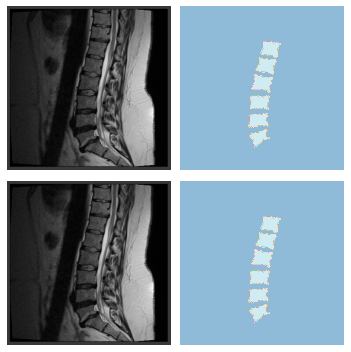

In [ ]:
dls.show_batch(unique=True, max_n=2, figsize=(5, 5)) 

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger, metrics=[multi_dice_score])

SuggestedLRs(valley=0.001737800776027143)

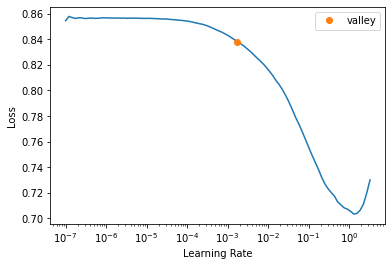

In [ ]:
lr=learn.lr_find()
lr 

In [ ]:
learn.fit_flat_cos(5 ,lr)

epoch,train_loss,valid_loss,multi_dice_score,time
0,0.818289,0.819564,0.236113,00:08
1,0.815933,0.817203,0.265275,00:07
2,0.814552,0.805336,0.262486,00:07
3,0.807869,0.792286,0.314553,00:07
4,0.801700,0.773624,0.378785,00:08


In [ ]:
learn.save('custom-model')

In [ ]:
store_variables(pkl_fn='models/vars.pkl', size=size, reorder=reorder, resample=resample)

## Inference on test data

### Download trained weights

In [ ]:
# Download the models from the study repository and cache them in the 'models' directory
models_path = Path(snapshot_download(repo_id="skaliy/spine-segmentation",  cache_dir='models'))

# Create a list of the models' file paths
model_list = ['/'.join((fn.parts[1:])) for fn in list(models_path.glob('*.pth'))]

In [ ]:
# Load the variables value from the specified file
size, reorder, resample = load_variables(pkl_fn=models_path/'vars.pkl')
size, reorder, resample

([16, 400, 400], True, [4.4, 0.78, 0.78])

### Download test data

In [ ]:
df_test = download_spine_test_data(path=DATA_DIR)

# Concatenate the original DataFrame and the test DataFrame
df = pd.concat([df, df_test], ignore_index=True)
df['is_test'].fillna(False, inplace=True)

### Create MedDataBlock and Learner

In [ ]:
# Create a MedDataBlock with the specified blocks, splitter, and item transformations
dblock = MedDataBlock(blocks=(ImageBlock(cls=MedImage), MedMaskBlock), 
                      splitter=ColSplitter('is_test'),
                      get_x=ColReader('t2_img_path'),
                      get_y=ColReader('t2_mask_path'),
                      item_tfms=[ZNormalization(), PadOrCrop(size)],
                      reorder=reorder,
                      resample=resample) 

In [ ]:
dls = dblock.dataloaders(df, bs=4)

In [ ]:
learn = Learner(dls, model, loss_func=loss_func, opt_func=ranger)

### Predict on test data and export learner 

In [ ]:
n_folds = len(model_list)
ensemble_acts = None

for idx, fn in enumerate(model_list): 
    
    # Load the model from the specified file
    learn.load(str(fn).split('.')[0])
    # Export the model
    learn.export(f'models/{idx}_learner.pkl')
    
    # Get the model's predictions on the data
    pred_acts, labels = learn.get_preds()
        
    # Add the predictions to the ensemble
    ensemble_acts = pred_acts if ensemble_acts is None else ensemble_acts + pred_acts

# Average the predictions of all the models in the ensemble
ensemble_acts = ensemble_acts/n_folds

In [ ]:
raw_preds,_ = batch_pred_to_multiclass_mask(ensemble_acts)
post_preds = [torch.Tensor(pred_postprocess(pred)) for pred in raw_preds]

In [ ]:
# Calculate the Dice score for the postprocessed masks
post_dsc = calculate_dsc(post_preds, labels)

# Calculate Hausdorff distance for the postprocessed masks
post_haus = calculate_haus(post_preds, labels)

In [ ]:
print(f'DSC: {torch.mean(post_dsc):.4f} \u00B1 {torch.std(post_dsc):.4f}')
print(f'Haus: {torch.mean(post_haus):.4f} \u00B1 {torch.std(post_haus):.4f}')

DSC: 0.8990 ± 0.0199
Haus: 12.0519 ± 11.6195


In [ ]:
df_test = df[1:].copy()
df_test['postprocessed_ensemble_dsc'] = post_dsc
df_test['postprocessed_ensemble_haus'] = post_haus
df_test = df_test.sort_values('subject_id').reset_index(drop=True)

In [ ]:
df_test

,t2_img_path,t2_mask_path,subject_id,is_val,is_test,postprocessed_ensemble_dsc,postprocessed_ensemble_haus
0,../data/chengwen_chu_2015/img/Img_01.nii.gz,../data/chengwen_chu_2015/seg/Img_01.nii.gz,01,NaN,True,0.921241,6.708204
1,../data/chengwen_chu_2015/img/Img_02.nii.gz,../data/chengwen_chu_2015/seg/Img_02.nii.gz,02,NaN,True,0.917546,4.242640
2,../data/chengwen_chu_2015/img/Img_03.nii.gz,../data/chengwen_chu_2015/seg/Img_03.nii.gz,03,NaN,True,0.880941,35.468296
3,../data/chengwen_chu_2015/img/Img_04.nii.gz,../data/chengwen_chu_2015/seg/Img_04.nii.gz,04,NaN,True,0.877997,18.601076
4,../data/chengwen_chu_2015/img/Img_05.nii.gz,../data/chengwen_chu_2015/seg/Img_05.nii.gz,05,NaN,True,0.927981,7.071068
5,../data/chengwen_chu_2015/img/Img_06.nii.gz,../data/chengwen_chu_2015/seg/Img_06.nii.gz,06,NaN,True,0.913778,8.062258
6,../data/chengwen_chu_2015/img/Img_07.nii.gz,../data/chengwen_chu_2015/seg/Img_07.nii.gz,07,NaN,True,0.902101,5.000000
7,../data/chengwen_chu_2015/img/Img_08.nii.gz,../data/chengwen_chu_2015/seg/Img_08.nii.gz,08,NaN,True,0.922395,5.477226
8,../data/chengwen_chu_2015/img/Img_09.nii.gz,../data/chengwen_chu_2015/seg/Img_09.nii.gz,09,NaN,True,0.901496,8.660254
9,../data/chengwen_chu_2015/img/Img_10.nii.gz,../data/chengwen_chu_2015/seg/Img_10.nii.gz,10,NaN,True,0.909481,4.582576


<b> Run `01-spine-segmentation-inference.ipynb` for inference on your own data.</b> 